In [ ]:
### NOTE:
### RUN VGG section only if you want VGG16 as your classifier.
### RUN RESNET section only if you want RESNET as your classifier.
### Do not just run the code altogether.
### It is recommended to use colab for this notebook.
### Please provide path to folder/models where asked.

# **Importing required Libraries**

In [ ]:
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.autograd import Function
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Data Loading**

In [ ]:
image_size = 224
batch_size = 5

pk_data = 'PATH_TO_PAK_DATASET_1'
pk_test = 'PATH_TO_PAK_DATASET_2'
west_data_tr = 'PATH_TO_RAF_DB_TRAINING_DATASET'
west_data_test = 'PATH_TO_RAF_DB_TESTING_DATASET'
vgg16_model_path = 'PATH_TO_VGG16_SAVED_MODEL'          ### This model will be updated in every epoch while training
resnet18_model_path = 'PATH_TO_RESNET18_SAVED_MODEL'    ### This model will be updated in every epoch while training


transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

pk_dataset = datasets.ImageFolder(pk_data , transform= transform_train)
pk_loader = torch.utils.data.DataLoader(pk_dataset, batch_size=batch_size, shuffle=True)

pk_dataset_test = datasets.ImageFolder(pk_test , transform= transform_train)
pk_loader_test = torch.utils.data.DataLoader(pk_dataset_test, batch_size=batch_size, shuffle=True)

west_dataset_tr = datasets.ImageFolder(west_data_tr , transform= transform_train)
west_loader_tr = torch.utils.data.DataLoader(west_dataset_tr, batch_size=batch_size, shuffle=True)

west_dataset_test = datasets.ImageFolder(west_data_test , transform= transform_train)
west_loader_test = torch.utils.data.DataLoader(west_dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
print('Source training data length: ', len(west_loader_tr.dataset))
print('Source testing data length: ', len(west_loader_test.dataset))
print('Target data 1 length: ', len(pk_loader.dataset))

Source training data length:  12271
Source testing data length:  3067
Target data 1 length:  2975


In [ ]:
print('Target data 2 length: ', len(pk_loader_test.dataset))
print('Target dataloader 2 length: ', len(pk_loader_test))

Target data 2 length:  725
Target dataloader 2 length:  145


# **Defining Some important functions**

In [ ]:
# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        # Store context for backprop
        ctx.alpha = alpha
        
        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Backward pass is just to -alpha the gradient
        output = grad_output.neg() * ctx.alpha

        # Must return same number as inputs to forward()
        return output, None

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Accuracy functions definition

In [ ]:
def accuracy_s(test_loader,model):
    correct = 0
    total = 0
    label_list= []
    pred_list = []
    with torch.no_grad():
        i = 1
        for data in test_loader:
            if i != 2455:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                label_list.extend(labels.cpu().numpy())
                pred_list.extend(predicted.cpu().numpy())
                i = i+1
          
    
    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    acc_score = accuracy_score(label_list, pred_list)
    print("Accuracy Score : ",acc_score)

    c_report =  classification_report(label_list,pred_list) 
    print("\n\nClassification Report")
    print(c_report)

    con_matrix = confusion_matrix(label_list, pred_list) 
    print("\n\nPrining Confusion Matrix: ")
    fig, ax = plt.subplots(figsize=(10,8))
    ticks = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    sns.heatmap(con_matrix, annot=True,cmap= 'Blues', xticklabels = ticks,  yticklabels = ticks)

In [ ]:
def accuracy(test_loader,model):
    correct = 0
    total = 0
    label_list= []
    pred_list = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            label_list.extend(labels.cpu().numpy())
            pred_list.extend(predicted.cpu().numpy())
          
    
    ## Going to Calculate Confusion Matrix and F1 Score Using SKLearn:

    acc_score = accuracy_score(label_list, pred_list)
    print("Accuracy Score : ",acc_score)

    c_report =  classification_report(label_list,pred_list) 
    print("\n\nClassification Report")
    print(c_report)

    con_matrix = confusion_matrix(label_list, pred_list) 
    print("\n\nPrining Confusion Matrix: ")
    fig, ax = plt.subplots(figsize=(10,8))
    ticks = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    sns.heatmap(con_matrix, annot=True,cmap= 'Blues', xticklabels = ticks,  yticklabels = ticks)

# **VGG16**

In [ ]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
for param in vgg16.features.parameters():
    param.require_grad = True

In [ ]:
vgg16.classifier = nn.Sequential(
                      nn.Linear(25088,480,bias=True), 
                      nn.ReLU(inplace= True),
                      nn.Dropout(p = 0.5,inplace=False),
                      nn.Linear(480,7,bias=True),
                      #nn.LogSoftmax(dim=1)                  
                     )
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
vgg16.load_state_dict(torch.load(vgg16_model_path))

In [ ]:
cls = vgg16.classifier
cls

In [ ]:
vgg16 = torch.nn.Sequential(*(list(vgg16.children())[:-1]))
vgg16.to(device)

In [ ]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16
        self.label_predictor = cls
        self.softMax = nn.Sequential(nn.LogSoftmax(dim=1))
        self.domain_classifier = nn.Sequential(
            nn.Linear(25088, 256), nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)

        features = self.vgg16(x)
        features = features.view(-1, 25088)
        
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        features = self.label_predictor(features)
        class_pred = self.softMax(features)

        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

In [ ]:
model = DACNN()
model.to(device)

x0_s, y0_s = next(iter(west_loader_tr))
x0_t, y0_t = next(iter(pk_loader))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s.to(device))
model(x0_t.to(device))

source domain:  torch.Size([5, 3, 224, 224]) torch.Size([5])
target domain:  torch.Size([5, 3, 224, 224]) torch.Size([5])


(tensor([[-8.2743e+00, -8.7074e+00, -9.6413e+00, -1.4786e+01, -1.2226e+00,
          -3.4955e-01, -1.0192e+01],
         [-1.5431e+01, -1.4971e+01, -1.1705e+01, -1.2475e+01, -5.9271e+00,
          -1.0176e+01, -2.7199e-03],
         [-5.2798e+00, -4.1593e+00, -3.3428e+00, -6.5765e+00, -3.1298e-01,
          -4.4616e+00, -1.6107e+00],
         [-7.5180e+00, -7.7030e+00, -5.3221e+00, -1.9414e+00, -1.7506e-01,
          -5.8063e+00, -4.8022e+00],
         [-6.7020e+00, -4.3474e+00, -8.0249e+00, -1.0235e+01, -1.9140e+00,
          -1.7692e-01, -8.9458e+00]], device='cuda:0',
        grad_fn=<LogSoftmaxBackward>), tensor([[-0.4513, -1.0127],
         [-0.5676, -0.8367],
         [-1.4509, -0.2670],
         [-0.6306, -0.7599],
         [-0.5105, -0.9168]], device='cuda:0', grad_fn=<LogSoftmaxBackward>))

# **ResNET18**

In [ ]:
resNet18 = models.resnet18(pretrained=True)
print(resNet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resNet18.parameters():
    param.require_grad = True

In [ ]:
resNet18.fc = nn.Sequential(
               nn.Linear(512, 480),
               nn.ReLU(inplace=True),
               nn.Linear(480, 7))

In [ ]:
resNet18.load_state_dict(torch.load(resnet18_model_path))

<All keys matched successfully>

In [ ]:
cls = resNet18.fc
cls

Sequential(
  (0): Linear(in_features=512, out_features=480, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=480, out_features=7, bias=True)
)

In [ ]:
resNet18 = torch.nn.Sequential(*(list(resNet18.children())[:-1]))
resNet18.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.resNet18 = resNet18
        self.label_predictor = cls
        self.softMax = nn.Sequential(nn.LogSoftmax(dim=1))
        self.domain_classifier = nn.Sequential(
            nn.Linear(512, 256), nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128), nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64), nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 2),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x, grl_lambda=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimention
        x = x.expand(x.data.shape[0], 3, image_size, image_size)

        features = self.resNet18(x)
        features = features.view(-1, 512)
        
        reverse_features = GradientReversalFn.apply(features, grl_lambda)
        
        features = self.label_predictor(features)
        class_pred = self.softMax(features)

        domain_pred = self.domain_classifier(reverse_features)
        
        return class_pred, domain_pred

In [ ]:
model = DACNN()
model.to(device)

x0_s, y0_s = next(iter(west_loader_tr))
x0_t, y0_t = next(iter(pk_loader))

print('source domain: ', x0_s.shape, y0_s.shape)
print('target domain: ', x0_t.shape, y0_t.shape)

model(x0_s.to(device))
model(x0_t.to(device))

source domain:  torch.Size([5, 3, 224, 224]) torch.Size([5])
target domain:  torch.Size([5, 3, 224, 224]) torch.Size([5])


(tensor([[-1.5123e+01, -1.2982e+01, -1.1056e+01, -4.1008e-05, -1.3832e+01,
          -1.0727e+01, -1.5121e+01],
         [-1.7530e+01, -1.3127e+01, -1.7194e+01, -5.0354e-04, -7.7206e+00,
          -9.7550e+00, -1.6851e+01],
         [-9.1643e+00, -1.4554e+01, -1.1480e+01, -7.7185e+00, -7.4664e+00,
          -1.5537e+01, -1.1330e-03],
         [-3.5343e+00, -3.5378e-01, -6.5834e+00, -2.0097e+00, -2.2381e+00,
          -4.1130e+00, -4.5694e+00],
         [-8.1005e+00, -6.6850e+00, -6.1562e+00, -6.1273e+00, -6.1823e+00,
          -9.3894e+00, -8.0371e-03]], device='cuda:0',
        grad_fn=<LogSoftmaxBackward>), tensor([[-0.6691, -0.7178],
         [-0.8947, -0.5255],
         [-0.7799, -0.6133],
         [-0.7270, -0.6604],
         [-1.0610, -0.4248]], device='cuda:0', grad_fn=<LogSoftmaxBackward>))

In [ ]:
model

DACNN(
  (resNet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


# **Training**

In [ ]:
lr = 1e-3

# Setup optimizer as usual
model = DACNN()

for param in model.parameters():
    param.require_grad = True

model.to(device)
optimizer = optim.Adam(model.parameters(), lr)

# Two losses functions this time
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [ ]:
dl_source = west_loader_tr
dl_target = pk_loader

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))
print('Max number of batches to run training: ', max_batches)

Max number of batches to run training:  595


In [ ]:
model.load_state_dict(torch.load(resnet18_model_path))
model.to(device)

DACNN(
  (resNet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
n_epochs = 100
for epoch_idx in range(n_epochs):
    st_time = time.time()
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        optimizer.zero_grad()
        # Training progress and GRL lambda
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        grl_lambda = 2. / (1. + np.exp(-10 * p)) - 1

        # Train on source domain
        X_s, y_s = next(dl_source_iter)
        X_s = X_s.to(device)
        y_s = y_s.to(device)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels
        y_s_domain = y_s_domain.to(device)

        class_pred, domain_pred = model(X_s, grl_lambda)
        loss_s_label = loss_fn_class(class_pred, y_s)
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain)

        # Train on target domain
        X_t, _ = next(dl_target_iter) # ignore target domain class labels!
        X_t = X_t.to(device)
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels
        y_t_domain = y_t_domain.to(device)

        _, domain_pred = model(X_t, grl_lambda)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain)
        
        loss = loss_t_domain + loss_s_domain + loss_s_label
        loss.backward()
        optimizer.step()
        
    print(f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
          f't_domain_loss: {loss_t_domain.item():.4f} ' f'grl_lambda: {grl_lambda:.3f} '
          )
    print('Time Taken: ', (time.time()-st_time)/60, 'minutes')
    torch.save(model.state_dict(), resnet18_model_path)

Epoch 0001 / 0100
class_loss: 0.5571 s_domain_loss: 0.8210 t_domain_loss: 0.6077 grl_lambda: 0.050 
Time Taken:  1.3404035607973734 minutes
Epoch 0002 / 0100
class_loss: 1.1324 s_domain_loss: 0.8387 t_domain_loss: 0.7219 grl_lambda: 0.100 
Time Taken:  1.337103796005249 minutes
Epoch 0003 / 0100
class_loss: 0.3421 s_domain_loss: 0.6955 t_domain_loss: 0.7664 grl_lambda: 0.149 
Time Taken:  1.3435718735059103 minutes
Epoch 0004 / 0100
class_loss: 0.4796 s_domain_loss: 0.8402 t_domain_loss: 0.5640 grl_lambda: 0.197 
Time Taken:  1.3354942321777343 minutes
Epoch 0005 / 0100
class_loss: 0.6936 s_domain_loss: 0.5675 t_domain_loss: 0.6767 grl_lambda: 0.245 
Time Taken:  1.334691826502482 minutes
Epoch 0006 / 0100
class_loss: 0.5305 s_domain_loss: 0.7141 t_domain_loss: 0.7068 grl_lambda: 0.291 
Time Taken:  1.3319151878356934 minutes
Epoch 0007 / 0100
class_loss: 0.4674 s_domain_loss: 0.6297 t_domain_loss: 0.7392 grl_lambda: 0.336 
Time Taken:  1.3429466207822165 minutes
Epoch 0008 / 0100
clas

# **Testing**

## Results for VGG16

Accuracy Score :  0.9780766096169519


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       705
           1       0.94      0.95      0.94       717
           2       0.96      0.92      0.94       281
           3       0.99      0.99      0.99      4772
           4       0.97      0.97      0.97      2524
           5       0.96      0.98      0.97      1981
           6       0.98      0.98      0.98      1290

    accuracy                           0.98     12270
   macro avg       0.97      0.97      0.97     12270
weighted avg       0.98      0.98      0.98     12270



Prining Confusion Matrix: 


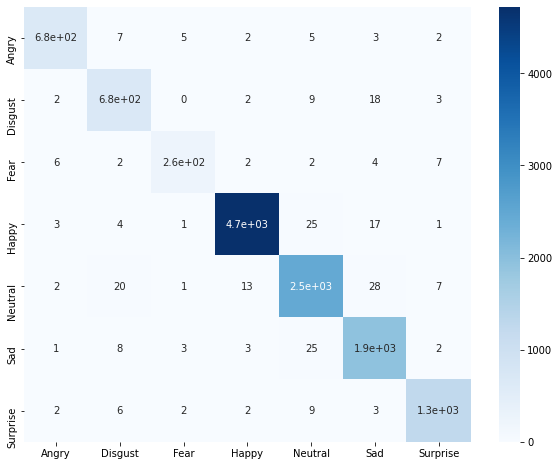

In [ ]:
accuracy_s(dl_source, model)

Accuracy Score :  0.5136134453781512


Classification Report
              precision    recall  f1-score   support

           0       0.06      0.03      0.04       157
           1       0.18      0.28      0.22       153
           2       0.10      0.02      0.03       111
           3       0.68      0.79      0.73       814
           4       0.67      0.49      0.57      1160
           5       0.23      0.42      0.30       269
           6       0.40      0.49      0.44       311

    accuracy                           0.51      2975
   macro avg       0.33      0.36      0.33      2975
weighted avg       0.53      0.51      0.51      2975



Prining Confusion Matrix: 


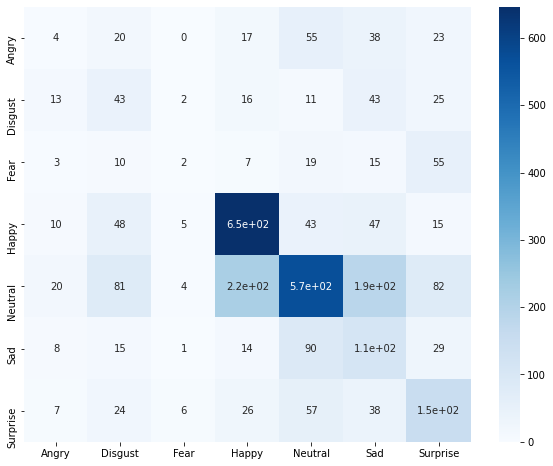

In [ ]:
accuracy(dl_target, model)

Accuracy Score :  0.3737931034482759


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.09      0.15       137
           1       0.19      0.14      0.16        74
           2       0.00      0.00      0.00        38
           3       0.46      0.78      0.58       138
           4       0.43      0.48      0.45       201
           5       0.12      0.14      0.13        70
           6       0.32      0.52      0.40        67

    accuracy                           0.37       725
   macro avg       0.30      0.31      0.27       725
weighted avg       0.37      0.37      0.33       725



Prining Confusion Matrix: 


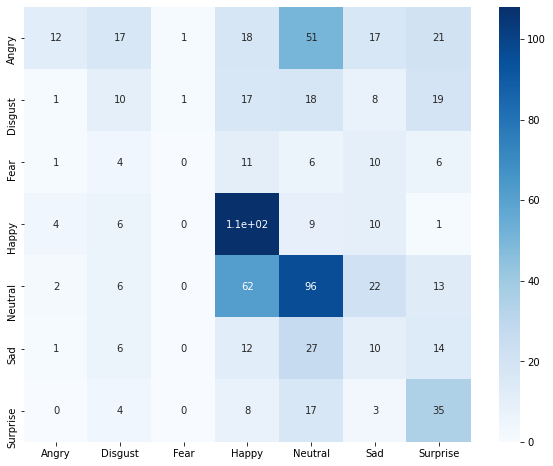

In [ ]:
accuracy(pk_loader_test, model)

## Results for ResNet18

Accuracy Score :  0.9809290953545232


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       705
           1       0.98      0.88      0.93       717
           2       0.94      0.96      0.95       281
           3       0.99      0.99      0.99      4772
           4       0.98      0.98      0.98      2523
           5       0.96      0.99      0.98      1982
           6       0.99      0.98      0.99      1290

    accuracy                           0.98     12270
   macro avg       0.97      0.97      0.97     12270
weighted avg       0.98      0.98      0.98     12270



Prining Confusion Matrix: 


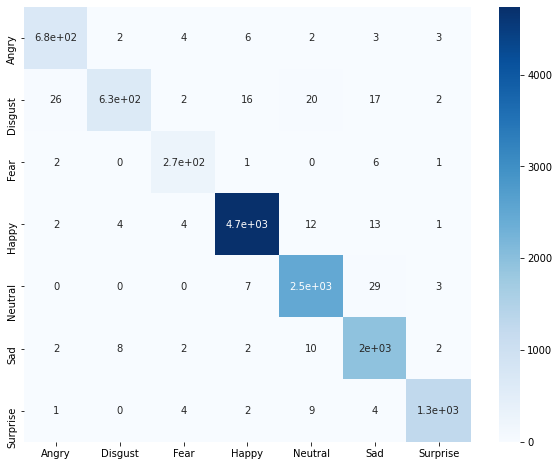

In [ ]:
accuracy_s(dl_source, model)

Accuracy Score :  0.4672268907563025


Classification Report
              precision    recall  f1-score   support

           0       0.08      0.08      0.08       157
           1       0.07      0.05      0.06       153
           2       0.09      0.04      0.05       111
           3       0.63      0.88      0.73       814
           4       0.63      0.36      0.45      1160
           5       0.20      0.39      0.26       269
           6       0.39      0.43      0.41       311

    accuracy                           0.47      2975
   macro avg       0.30      0.32      0.29      2975
weighted avg       0.49      0.47      0.45      2975



Prining Confusion Matrix: 


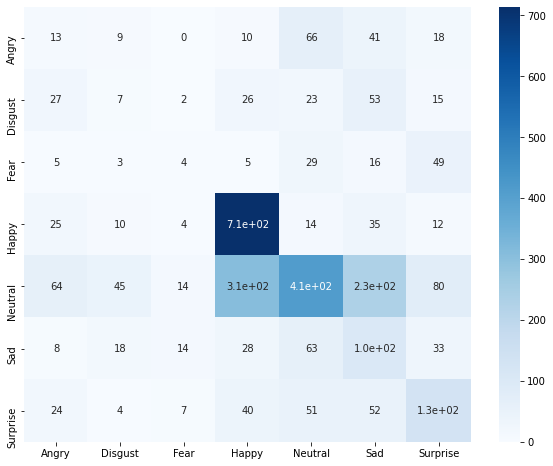

In [ ]:
accuracy(dl_target, model)

Accuracy Score :  0.32413793103448274


Classification Report
              precision    recall  f1-score   support

           0       0.44      0.08      0.14       137
           1       0.00      0.00      0.00        74
           2       0.09      0.03      0.04        38
           3       0.45      0.86      0.59       138
           4       0.36      0.35      0.35       201
           5       0.10      0.17      0.12        70
           6       0.26      0.34      0.29        67

    accuracy                           0.32       725
   macro avg       0.24      0.26      0.22       725
weighted avg       0.30      0.32      0.28       725



Prining Confusion Matrix: 


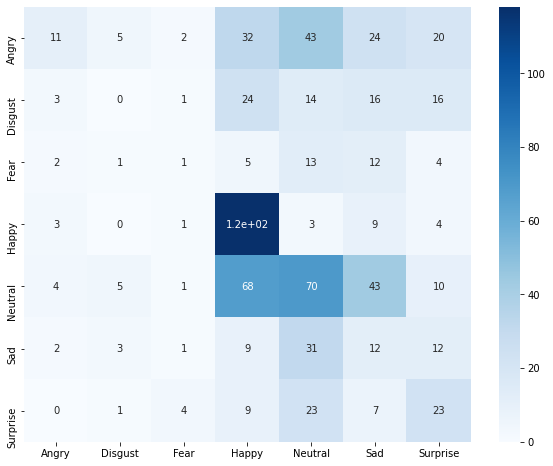

In [ ]:
accuracy(pk_loader_test, model)